# Focusing on the whole SPIDER (using fixed cube)

________________________________________________________________________________________________________________________

## Import all python libraries

Here, I am importing all python libraries I will be using

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from ROHSApy import ROHSA
from scipy.optimize import curve_fit
import random
from scipy.stats import norm

# For the mosaic of the maps
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
from matplotlib.ticker import ScalarFormatter

## Download the cube data

The first thing I need to do is download the data cube. I went to the address: https://www.cita.utoronto.ca/GHIGLS/ to download the data cube. The designated region I am working with is the SPIDER region. 

In [2]:
#!wget https://www.cita.utoronto.ca/GHIGLS/FITS/GHIGLS_SPIDER_Tb.fits

I am also installing ROHSApy.

In [3]:
#!pip install ROHSApy

## Load the data cube

inpainted cube (new cube)

In [4]:
# Now I need to load the data cube that I collected in the above step.
fitsname = "new_cube_inpaint.fits"
hdu = fits.open(fitsname)
hdr = hdu[0].header
cube = hdu[0].data[:,:,:]
# In the PPV cube, there are 3 axes (Representing the three spaces in the list).
# The first is the velocity axis. The others represent the position coordinates, x and y.

GHIGLS cube (old cube)

In [5]:
# Now I need to load the data cube that I collected in the above step.
fitsname_GHIGLS = "GHIGLS_SPIDER_Tb.fits"
hdu_GHIGLS = fits.open(fitsname_GHIGLS)
hdr_GHIGLS = hdu_GHIGLS[0].header
cube_GHIGLS = hdu_GHIGLS[0].data[0][:,:,:]
# In the PPV cube, there are 3 axes (Representing the three spaces in the list).
# The first is the velocity axis. The others represent the position coordinates, x and y.

Need to adjust the header for the axis to be in velocity rather than pixel units

In [6]:
hdr["NAXIS3"] = 155 # The range of subvel (end_subvel - start_subvel)
hdr["CRPIX3"] -= 360 # This is to fix the position of the peaks to have the right index and velocity

In [7]:
hdr_GHIGLS["NAXIS3"] = 155 # The range of subvel (end_subvel - start_subvel)
hdr_GHIGLS["CRPIX3"] -= 360 # This is to fix the position of the peaks to have the right index and velocity

In order to get the axis to be in units of velocity, need this function which converts pixel units to velocity (km/s)

In [8]:
def spec_2_velocity(CRVAL, CDELT, CRPIX, index):
    '''
    Description: 
        This function takes in the parameters from the header and adjusts the \
        velocity range so that is centers at zero (based on the reference). 
    
    Parameters:
        CRVAL - The value of the reference velocity - float
        CDELT - The value of the channel spacing - float
        CRPIX - The value of the pixel where CRVAL occurs - float
    
    Returns:
        This function returns the adjusted velocity list - list
    '''
    vel = [(CRVAL + CDELT * (index[i] - CRPIX)) for i in range(len(index))]
    # Puts in units of km/s
    
    return vel

In [9]:
index_arr = np.arange(cube.shape[0])

cdelt3 = hdr["CDELT3"]/1000. #This allows it to be in units of km/s rather than m/s
crpix3 = hdr["CRPIX3"]
crval3 = hdr["CRVAL3"]/1000. #This allows it to be in units of km/s rather than m/s

vel = np.array(spec_2_velocity(crval3,cdelt3,crpix3,index_arr))

## Function for producing Gaussians

Here, I define a function for a gaussian function. I will be plotting some gaussians manually, so I need this function for later

In [10]:
# Some constants for the integrals:
dv = abs(cdelt3)
C = 1.82243e18

In [11]:
# Function for a single Gaussian 
def one_gauss_func(x, amp, cent, sigma):
    '''
    Description: 
        Evaluates a Gaussian function given some parameters
    
    Parameters:
        x - Value at which the Gaussian is evaluated at - float
        amp - The amplitude of the Gaussian - float
        cent - The location of the of the peak - float 
        sigma - The width of the peak - float
    
    Returns:
        The function evaluated at x - float
    '''
    return amp*np.exp(-(x-cent)**2/(2*sigma**2))

## Define the limits and the region

I want to look at the whole SPIDER over the full x and y axes. This can help give some information about the whole SPIDER and let us generalize some trends we see. I can limit the velocity range to zoom in on the LVC and IVC regions.

In [12]:
idx_lim_left = 360; idx_lim_right = 515 

subvel_whole_spider = vel[:idx_lim_right-idx_lim_left]
subcube_whole_spider = cube[idx_lim_left:idx_lim_right, :, :] # Want the whole spider, so full x and y axes
subcube_GHIGLS_whole_spider = cube_GHIGLS[idx_lim_left:idx_lim_right, :, :]

I can first just plot a random spectrum, then also plot the average spectrum, which will give us more information

In [13]:
# x_rand = 70; y_rand = 110 #interesting point 
# x_rand = 113; y_rand = 145 #interesting point 
# x_rand = 154; y_rand = 23 #interesting point 

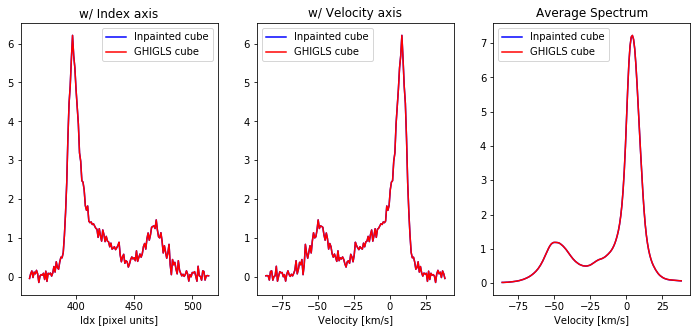

In [14]:
x_rand = random.randint(0,170) ; y_rand = random.randint(0,171)

plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.title("w/ Index axis"); plt.xlabel("Idx [pixel units]")
plt.plot(index_arr[idx_lim_left:idx_lim_right], cube[idx_lim_left:idx_lim_right,y_rand, x_rand], 'b-', label="Inpainted cube")
plt.plot(index_arr[idx_lim_left:idx_lim_right], cube_GHIGLS[idx_lim_left:idx_lim_right,y_rand, x_rand], 'r-', label="GHIGLS cube")
plt.legend(loc="upper right")

plt.subplot(1,3,2)
plt.title("w/ Velocity axis"); plt.xlabel("Velocity [km/s]")
plt.plot(subvel_whole_spider, cube[idx_lim_left:idx_lim_right,y_rand,x_rand], 'b-', label="Inpainted cube")
plt.plot(subvel_whole_spider, cube_GHIGLS[idx_lim_left:idx_lim_right,y_rand,x_rand], 'r-', label="GHIGLS cube")
plt.legend(loc="upper left")

plt.subplot(1,3,3)
avg_whole_spider = np.mean(subcube_whole_spider, (1,2))
avg_whole_spider_GHIGLS = np.mean(subcube_GHIGLS_whole_spider, (1,2))
plt.title("Average Spectrum")
plt.plot(subvel_whole_spider, avg_whole_spider, 'b-', label="Inpainted cube")
plt.plot(subvel_whole_spider, avg_whole_spider_GHIGLS, 'r-', label="GHIGLS cube")
plt.xlabel("Velocity [km/s]")
plt.legend(loc="upper left")

plt.show()

## Standard Deviation Spectra of the cubes

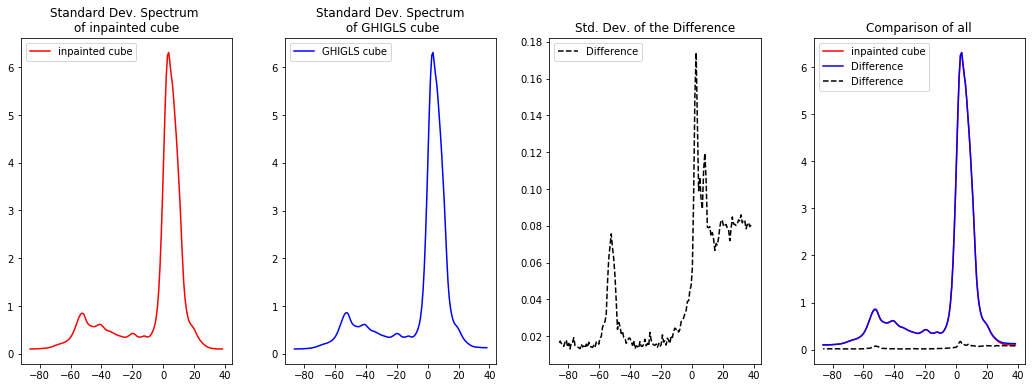

In [15]:
fig = plt.figure(figsize=(18,6))
plt.subplot(1,4,1) ; plt.title("Standard Dev. Spectrum \nof inpainted cube")
plt.plot(subvel_whole_spider, np.std(subcube_whole_spider, (1,2)), 'r-', label="inpainted cube"); plt.legend(loc="upper left")
plt.subplot(1,4,2) ; plt.title("Standard Dev. Spectrum\n of GHIGLS cube")
plt.plot(subvel_whole_spider, np.std(subcube_GHIGLS_whole_spider, (1,2)),'b-', label="GHIGLS cube"); plt.legend(loc="upper left")
plt.subplot(1,4,3) ; plt.title("Std. Dev. of the Difference")
#plt.plot(subvel_whole_spider, np.std(subcube_GHIGLS_whole_spider, (1,2))-np.std(subcube_whole_spider, (1,2)),'k--', label="GHIGLS cube")
plt.plot(subvel_whole_spider, np.std(subcube_whole_spider - subcube_GHIGLS_whole_spider, (1,2)),'k--', label="Difference")
plt.legend(loc="upper left")
plt.subplot(1,4,4) ; plt.title("Comparison of all")
plt.plot(subvel_whole_spider, np.std(subcube_whole_spider, (1,2)), 'r-', label="inpainted cube"); plt.legend()
plt.plot(subvel_whole_spider, np.std(subcube_GHIGLS_whole_spider, (1,2)),'b-', label="Difference"); plt.legend()
plt.plot(subvel_whole_spider, np.std(subcube_whole_spider - subcube_GHIGLS_whole_spider, (1,2)),'k--', label="Difference")
#plt.plot(subvel_whole_spider, np.std(subcube_GHIGLS_whole_spider, (1,2))-np.std(subcube_whole_spider, (1,2)),'k--', label="GHIGLS cube")
plt.legend(loc="upper left") 
plt.subplots_adjust(wspace=0.25); plt.show()

fig.savefig("Comparison_of_StdDev_Spectra_for_GHIGLS_and_inpainted_cube.pdf", bbox_inches='tight')

## Noise Map

This channel is the one where the SPIDER is most prominent. It is interesting to see how noisy it is.


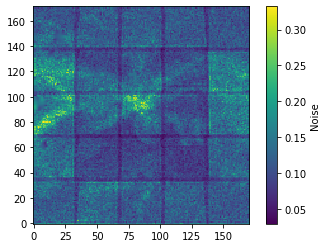

In [16]:
fig = plt.figure()
noise_cube = cube[:24] # Using the first 24 channels of the index axis.
noise_map = np.std(noise_cube, 0)

rms = np.array([noise_map[:,:]*(1+channel/20) for channel in subcube_whole_spider])

plt.imshow(rms[42], origin='lower')
plt.colorbar(label='Noise')

print("This channel is the one where the SPIDER is most prominent. It is interesting to see how noisy it is.")
fig.savefig("Noise_map_whole_spider.pdf", bbox_inches='tight')

## Getting ROHSA to analyze a region

In [17]:
#!git clone https://github.com/antoinemarchal/ROHSA.git ROHSA
#import os
#os.chdir('ROHSA/src')
#!make
#os.chdir('../../')

## Define the ROHSA parameters

Now to set up the parameters for the Gaussian decomposition.

In [18]:
filename = "GHIGLS_SPIDER_Tb_new_cube.dat" #@param
fileout = "GHIGLS_SPIDER_Tb_gauss_run_whole_spider_new_cube_1_10_Noise3D.dat" #@param
filename_parameters = "parameters_whole_spider_new_cube_1_10_Noise3D.txt"
filename_noise = 'Noise_Map_1_10.dat'
n_gauss = 24          #@param {type:"slider", min:1, max:12, step:1}                                                                                                                                                                                                                             
lambda_amp = 1      #@param {type:"slider", min:0, max:1000, step:1}
lambda_mu = 1       #@param {type:"slider", min:0, max:1000, step:1}
lambda_sig = 1      #@param {type:"slider", min:0, max:1000, step:1}
lambda_var_amp = 0.                                                                                                                                                                                                                                                           
lambda_var_mu = 0.                                                                                                                                                                                                                                                        
lambda_var_sig = 10  #@param {type:"slider", min:0, max:10000, step:1}                                                                                                                                                                                                                                                            
amp_fact_init = 0.66  # times max amplitude of additional Gaussian                                                                                                                                                                                                                                                          
sig_init = 4.         # dispersion of additional Gaussian                                                                                                                                                                                                                                                                   
init_option = 'mean'  # init ROHSA with the mean or the std spectrum                                                                                                                                                                                                                                                      
maxiter_init = 15000  # max iteration for L-BFGS-B alogorithm init mean                                                                                                                                                                                                                                        
maxiter = 800         #@param {type:"slider", min:1, max:800, step:1}                                                                                                                                                                                                                                                         
m = 10                # number of corrections used in the limited memory matrix                                                                                                                                                                                                                               
noise = ".true."     # if false - STD map computed by ROHSA with lstd and ustd                                                                                                                                                                                                           
regul = ".true."      # if true - activate regulation                                                                                                                                                                                                                                                                 
descent = ".true."    #@param [".true.", ".false."]                                                                                                                                                                                                                       
lstd = 1              #@param {type:"slider", min:1, max:400, step:1}                                                                                                                                                                                                                
ustd = 20             #@param {type:"slider", min:1, max:400, step:1}                                                                                                                                                                                                                 
iprint = -1           #@param ["-1", "0", "1"]                                                                                                                                                                                                                                                                                      
iprint_init = -1      # print option init                                              
save_grid = ".false." #@param [".true.", ".false."] 
lb_sig_init = 0.1
ub_sig_init = 10.
lb_sig = 0.1
ub_sig = 100.

core = ROHSA(subcube_whole_spider, hdr=hdr)  
core_rms = ROHSA(rms)
core.cube2dat(filename=filename)
core_rms.cube2dat(filename=filename_noise)
core.gen_parameters(filename=filename, 
                    fileout=fileout,
                    filename_noise=filename_noise,
                    filename_parameters=filename_parameters,
                    n_gauss=n_gauss,
                    lambda_amp=lambda_amp,
                    lambda_mu=lambda_mu,
                    lambda_sig=lambda_sig,
                    lambda_var_sig=lambda_var_sig,
                    noise=noise,
                    maxiter=maxiter,
                    descent=descent,
                    lstd=lstd,
                    ustd=ustd,
                    iprint=iprint,
                    lb_sig_init=lb_sig_init,
                    ub_sig_init=ub_sig_init,
                    lb_sig = lb_sig,
                    ub_sig = ub_sig,
                    save_grid=save_grid)

Generate GHIGLS_SPIDER_Tb_new_cube.dat file readable by fortran
Generate Noise_Map_1_10.dat file readable by fortran
Generate parameters_whole_spider_new_cube_1_10_Noise3D.txt file


In [19]:
#! ./ROHSA/src/ROHSA parameters_whole_spider_new_cube_1_10_Noise3D.txt

## Obtain the Gaussian parameters for the decomposition

In [20]:
gaussian_whole_spider = core.read_gaussian("GHIGLS_SPIDER_Tb_gauss_run_whole_spider_new_cube_1_10_Noise3D.dat")
params = core.physical_gaussian(gaussian_whole_spider)

print("dim cube = " + str(gaussian_whole_spider.shape))

model_whole_spider = core.return_result_cube(gaussian=gaussian_whole_spider)

# Physical Space
amplitude_whole_spider = gaussian_whole_spider[0::3]
position_whole_spider = np.array(spec_2_velocity(crval3,cdelt3,crpix3,gaussian_whole_spider[1::3]))
dispersion_whole_spider = gaussian_whole_spider[2::3]

# "Pixel" Space
amplitude_pix = gaussian_whole_spider[0::3]
position_pix = gaussian_whole_spider[1::3]
dispersion_pix = gaussian_whole_spider[2::3]* dv

integral_whole_spider = amplitude_whole_spider * dispersion_whole_spider * np.sqrt(2*np.pi) 

Opening data file
dim cube = (72, 172, 171)


In [21]:
NHI_map_whole_spider = integral_whole_spider * C

## Plot a Spectrum

Now, I want to plot a random spectrum / pixel in this region

In [22]:
def plot_spect(x_pos, y_pos, vel, model, cube, gaussian, model2="None", caption=""):
    fig = plt.figure(figsize=(8,6))
    plt.xlabel("$v$ [$km$ $s^{-1}$]")
    plt.ylabel("$T_{b}$ [$K$]")
    plt.plot(vel, cube, color='cornflowerblue',  label="data")
    plt.plot(vel, model , 'r', label="model (pix by pix)")
    if model2 != "None":
        plt.plot(vel, model2 , 'g', label="model (comp by comp)")
    
    # To plot all the gaussians under the model and data:
    for i in range(n_gauss):
            plt.plot(vel, core.gauss(np.arange(len(vel)), \
                                              gaussian[0::3][i][y_pos,x_pos],\
                                              gaussian[1::3][i][y_pos,x_pos],\
                                              gaussian[2::3][i][y_pos,x_pos]), 'k')
    plt.legend()
    plt.show()
    fig.savefig(caption, bbox_inches="tight")

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='upper right')

def plot_spect_color(x, y, v, model, cube, gaussian, caption=""):
    fig = plt.figure(figsize=(12,6.5))
    ax = fig.add_subplot(111)
    ax.set_xlabel("v [$km$ $s^{-1}$]")
    ax.set_ylabel("T$_{b}$ [$K$]")
    ax.plot(v, cube, color='green',  label="data")
    ax.plot(v, model , color='black', label="model")
    
    # To plot all the gaussians under the model and data:
    for i in range(n_gauss):
        gauss = core.gauss(np.arange(len(v)), gaussian[0::3][i][y,x], gaussian[1::3][i][y,x], gaussian[2::3][i][y,x])
        if gaussian[2::3][i][y,x] < 3.:
            ax.plot(v, gauss, color='deepskyblue', label="CNM")
            #ax.fill_between(v, gauss.min(), gauss, facecolor="____", alpha=0.2)
        if gaussian[2::3][i][y,x] >=3. and gaussian[2::3][i][y,x] < 6.:
            ax.plot(v, gauss, color='darkorchid', label="UNM")
            #ax.fill_between(v, gauss.min(), gauss, facecolor="____", alpha=0.2)
        if gaussian[2::3][i][y,x] >= 6.:
            ax.plot(v, gauss, color='red', label="WNM")
            #ax.fill_between(v, gauss.min(), gauss, facecolor="____, alpha=0.2)
            
    legend_without_duplicate_labels(ax)
    plt.show()
    #fig.savefig(caption, bbox_inches="tight")

In [23]:
#x_pos_whole_spider = 111 ; y_pos_whole_spider = 132
#x_pos_whole_spider = 38 ; y_pos_whole_spider = 94
#x_pos_whole_spider = 119 ; y_pos_whole_spider = 69

x =  39
y =  56


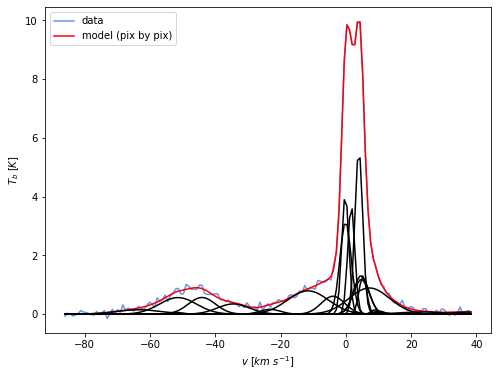

In [24]:
x_pos_whole_spider = random.randint(0,168); y_pos_whole_spider = random.randint(0,168)
print("x = ", x_pos_whole_spider) ; print("y = ", y_pos_whole_spider)

plot_spect(x_pos_whole_spider, y_pos_whole_spider, subvel_whole_spider,\
           model_whole_spider[:, y_pos_whole_spider, x_pos_whole_spider], \
           subcube_whole_spider[:, y_pos_whole_spider, x_pos_whole_spider], gaussian_whole_spider, \
           caption="random_spectrum_whole_spider")

## Chi Squared Map

#### Map of $\chi^{2}$

In [25]:
noise_cube = cube[:24] # Using the first 24 channels of the index axis.
noise_map = np.std(noise_cube, 0)

rms = np.array([noise_map[:,:]*(1+channel/20) for channel in subcube_whole_spider])

In [26]:
N_model = model_whole_spider # Gaussian model 
N_data = subcube_whole_spider # Actual spectrum data
diff = (N_data - N_model)
        
chi_sq_map = np.sum((diff / rms)**2, 0)

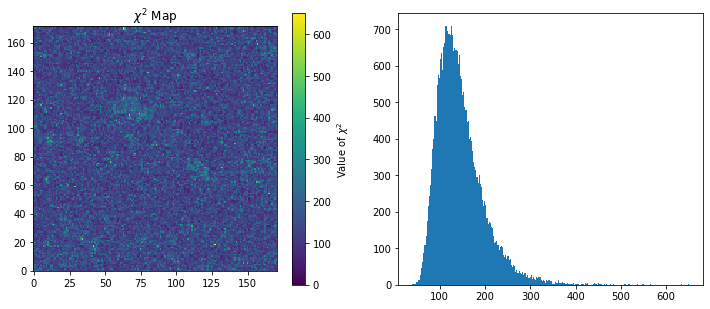

mean =  145.6199102560696
sigma =  52.33133812831696


In [27]:
fig = plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("$\chi^{2}$ Map")
plt.imshow(chi_sq_map, origin='lower', vmin=0) ; plt.colorbar(label="Value of $\chi^{2}$")
plt.subplot(1,2,2)
y, x, _ = plt.hist(chi_sq_map.ravel(), bins=250)
plt.show()

print("mean = ",np.mean(chi_sq_map))
print("sigma = ",np.sqrt(np.var(chi_sq_map)))
#print(np.sqrt(2*free_params) / free_params)

fig.savefig("Chi_Squared_map_and_Histogram_whole_spider.pdf", bbox_inches='tight')

x =  127
y =  18
This spectrum represents the pixel with the highest chi-squared value.
value of chi suqared for this spectrum:  650.3811004420147


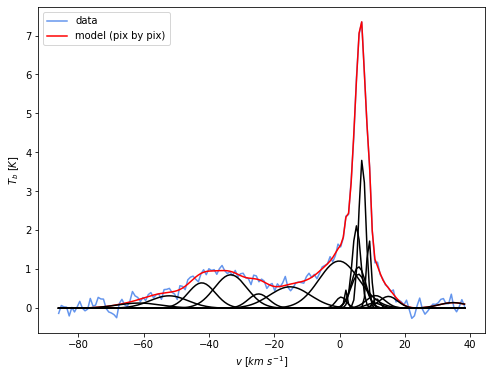

In [28]:
y_pos_whole_spider, x_pos_whole_spider = np.unravel_index(chi_sq_map.argmax(), chi_sq_map.shape)
print("x = ", x_pos_whole_spider) ; print("y = ", y_pos_whole_spider)
print("This spectrum represents the pixel with the highest chi-squared value.")
print("value of chi suqared for this spectrum: ",chi_sq_map[y_pos_whole_spider][x_pos_whole_spider])

#y_pos_whole_spider = 73 ; x_pos_whole_spider = 117
plot_spect(x_pos_whole_spider, y_pos_whole_spider, subvel_whole_spider,\
           model_whole_spider[:, y_pos_whole_spider, x_pos_whole_spider], \
           subcube_whole_spider[:, y_pos_whole_spider, x_pos_whole_spider], gaussian_whole_spider, \
           caption="spectrum_with_highest_chi_sq.pdf")

#### $\chi^{2}$ Contribution

In [29]:
chi_sq_contrib = (diff / rms)**2

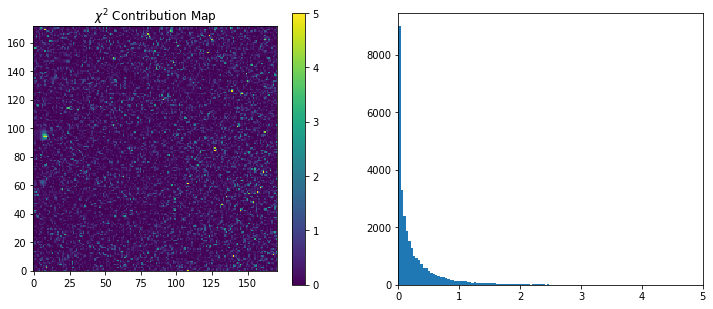

mean = 0.28254454902005277


In [30]:
channel = 42
fig = plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("$\chi^{2}$ Contribution Map")
plt.imshow(chi_sq_contrib[channel], origin='lower', vmin=0, vmax=5.) ; plt.colorbar()
plt.subplot(1,2,2)
plt.xlim(0,5)
y_chisq_contrib, x_chisq_contrib, _chisq_contrib = plt.hist(chi_sq_contrib[channel].ravel(), bins=250, range=[0,10])
plt.show()

print("mean =", np.mean(chi_sq_contrib[channel]))

fig.savefig("Chi_Squared_Contribution_map_and_Histogram_whole_spider.pdf", bbox_inches='tight')

## Plot a mosaic of spectra

<Figure size 432x288 with 0 Axes>

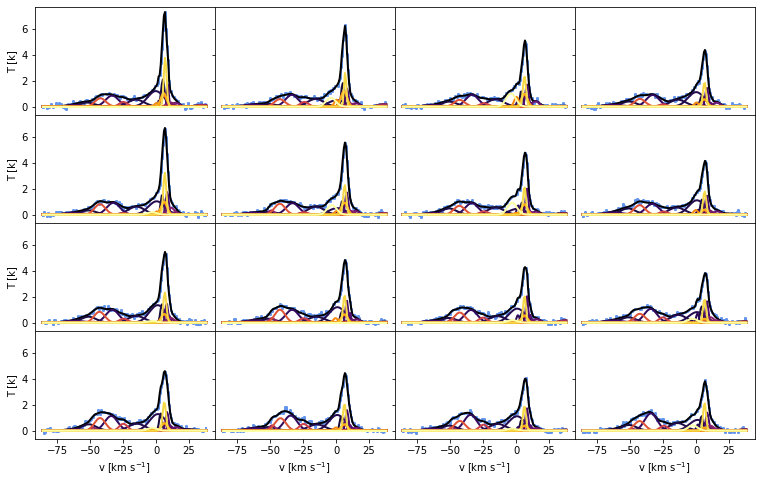

In [31]:
# Mosaic of the Spectra

pvalues = np.logspace(-1, 0, n_gauss)
pmin = pvalues[0]
pmax = pvalues[-1]

def norm(pval):
    return (pval - pmin) / float(pmax - pmin)

f = plt.figure()
ny = 4; nx = 4
center_y = y_pos_whole_spider; center_x = x_pos_whole_spider
cb = "magenta"
cw = "crimson"
fig, axs = plt.subplots(nx, ny, sharex=True, sharey=True, figsize=(10.,6.))
fig.subplots_adjust(hspace=0, wspace=0, left=0, right=1, top=1, bottom=0)
for i in np.arange(ny):
    for j in np.arange(nx):
        axs[i][j].step(subvel_whole_spider, subcube_whole_spider[:,center_y+i,center_x+j], color='cornflowerblue', linewidth=2.)
        axs[i][j].plot(subvel_whole_spider, model_whole_spider[:,center_y+i,center_x+j], linestyle="-", linewidth=2., color="k")
        for k in range(n_gauss):
            axs[i][j].plot(subvel_whole_spider, core.gauss(np.arange(len(subvel_whole_spider)), gaussian_whole_spider[0::3][k][center_y+i,center_x+j],
                                              gaussian_whole_spider[1::3][k][center_y+i,center_x+j], gaussian_whole_spider[2::3][k][center_y+i,center_x+j]),
                           linewidth=2., color=plt.cm.inferno(pvalues[k]))
        if j == 0: axs[i][j].set_ylabel(r'T [k]')
        axs[i][j].set_xlabel(r'v [km s$^{-1}$]')
f.savefig("Mosaic_of_Spectra_whole_spider.pdf", bbox_inches='tight')

#plt.savefig("plot/" + 'mosaic_spectra_all.png', format='png', bbox_inches='tight', pad_inches=0.02)

## 2D Histogram

In [32]:
iddx = np.argsort(np.mean(position_whole_spider, axis=(1,2)))
field = [NHI_map_whole_spider[idd] for idd in iddx]
vfield = [position_whole_spider[idd] for idd in iddx]
ampfield = [amplitude_whole_spider[idd] for idd in iddx]
sigfield = [dispersion_whole_spider[idd] for idd in iddx]

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10


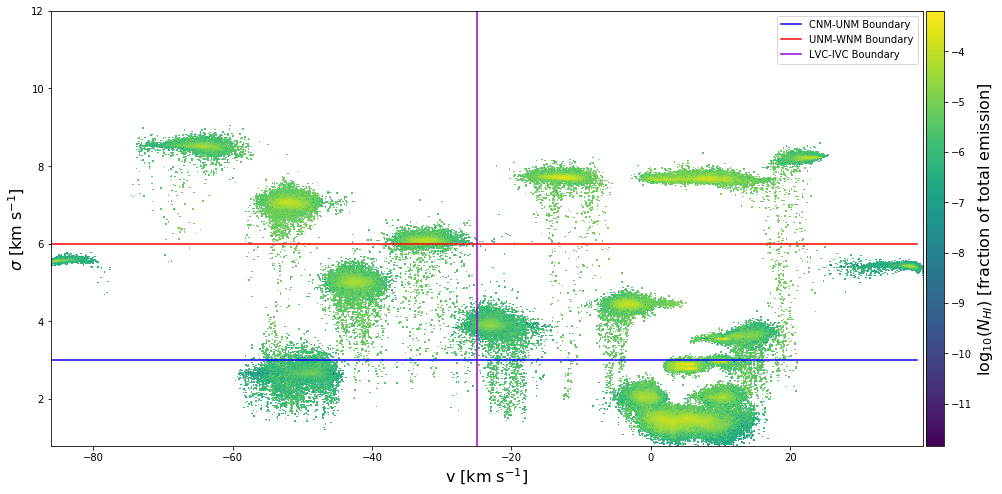

In [33]:
#HEATMAP 
x_bins = np.linspace(np.min(position_whole_spider.ravel()), np.max(position_whole_spider.ravel()), 1200)
y_bins = np.linspace(0.8,12., 1200)
H, xedges, yedges = np.histogram2d(position_whole_spider.ravel(), dispersion_whole_spider.ravel(),
                                   weights=np.sqrt(2.*np.pi)*amplitude_whole_spider.ravel()*(dispersion_whole_spider.ravel())*C/np.sum(field),
                                   bins=[x_bins, y_bins])
H = np.ma.masked_invalid(np.atleast_2d(H))
fig = plt.figure(figsize=(16.,8.))
plt.plot(subvel_whole_spider, 3*np.ones_like(subvel_whole_spider), 'b-', label="CNM-UNM Boundary")
plt.plot(subvel_whole_spider, 6*np.ones_like(subvel_whole_spider), 'r-', label="UNM-WNM Boundary")
plt.axvline(x=-25, color='darkviolet', label="LVC-IVC Boundary")
plt.legend(loc='upper right')
ax = fig.add_subplot(111)
ax.set_ylim([0.8, 12.])
ax.set_xlim([np.min(position_whole_spider.ravel()),np.max(position_whole_spider.ravel())])
ax.set_xlabel(r'v [km s$^{-1}$]',  fontsize = 16)
ax.set_ylabel(r'$\sigma$ [km s$^{-1}$]',  fontsize = 16)
ax.yaxis.set_major_formatter(ScalarFormatter())
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2%', pad=0.05)
im = ax.pcolormesh(xedges, yedges, np.log10(H.T), cmap="viridis")
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label(r'log$_{10}$($N_{HI}$) [fraction of total emission]', fontsize = 16)
fig.savefig("2D_Histogram_heat_map_whole_spider.png", bbox_inches="tight")
#plt.savefig("plot/" + 'heatmap.png', format='png', bbox_inches='tight', pad_inches=0.02)

## Maps of the LVC and IVC regions (CNM and WNM)

The first method is the sort the Gaussians based on if they are LVC or IVC and if they are CNM, UNM or WNM. Here, I analyze every pixel in the cube and sort the Gaussians that way. This was is very accurate as every Gaussian is accounted for. In each pixel, the ROHSA decomposition is different, so I want to look at each pixel separately and sort like that rather than take the average of each Gaussian.

In [34]:
def phase_cubes_pix_by_pix(subcube, n_gauss, position, dispersion, amplitude_pix, position_pix, dispersion_pix):
    model_LVC_CNM = np.zeros(subcube.shape)
    model_LVC_UNM = np.zeros(subcube.shape)
    model_LVC_WNM = np.zeros(subcube.shape)

    model_IVC_CNM = np.zeros(subcube.shape)
    model_IVC_UNM = np.zeros(subcube.shape)
    model_IVC_WNM = np.zeros(subcube.shape)
    
    for i in range(subcube.shape[1]):
        for j in range(subcube.shape[2]):
            for n in range(n_gauss):
                
                # LVC CNM
                if position[n][i][j] > -25. and dispersion[n][i][j] < 3.:
                    spectrum_LVC_CNM = one_gauss_func(np.arange(subcube.shape[0]), amplitude_pix[n][i][j], \
                                                  position_pix[n][i][j], dispersion_pix[n][i][j]/dv)
                    model_LVC_CNM[:, i, j] += spectrum_LVC_CNM
                  
                # LVC UNM
                if position[n][i][j] > -25. and dispersion[n][i][j] >= 3. and dispersion[n][i][j] < 6.:
                    spectrum_LVC_UNM = one_gauss_func(np.arange(subcube.shape[0]), amplitude_pix[n][i][j], \
                                                  position_pix[n][i][j], dispersion_pix[n][i][j]/dv)
                    model_LVC_UNM[:, i, j] += spectrum_LVC_UNM
                
                # LVC WNM
                if position[n][i][j] > -25. and dispersion[n][i][j] >= 6.:
                    spectrum_LVC_WNM = one_gauss_func(np.arange(subcube.shape[0]), amplitude_pix[n][i][j], \
                                                  position_pix[n][i][j], dispersion_pix[n][i][j]/dv)
                    model_LVC_WNM[:, i, j] += spectrum_LVC_WNM
                    
                # IVC CNM
                if position[n][i][j] < -25. and dispersion[n][i][j] < 3.:
                    spectrum_IVC_CNM = one_gauss_func(np.arange(subcube.shape[0]), amplitude_pix[n][i][j], \
                                                  position_pix[n][i][j], dispersion_pix[n][i][j]/dv)
                    model_IVC_CNM[:, i, j] += spectrum_IVC_CNM
                  
                # IVC UNM
                if position[n][i][j] < -25. and dispersion[n][i][j] >= 3. and dispersion[n][i][j] < 6.:
                    spectrum_IVC_UNM = one_gauss_func(np.arange(subcube.shape[0]), amplitude_pix[n][i][j], \
                                                  position_pix[n][i][j], dispersion_pix[n][i][j]/dv)
                    model_IVC_UNM[:, i, j] += spectrum_IVC_UNM
                
                # IVC WNM
                if position[n][i][j] < -25. and dispersion[n][i][j] >= 6.:
                    spectrum_IVC_WNM = one_gauss_func(np.arange(subcube.shape[0]), amplitude_pix[n][i][j], \
                                                  position_pix[n][i][j], dispersion_pix[n][i][j]/dv)
                    model_IVC_WNM[:, i, j] += spectrum_IVC_WNM
    
    return model_LVC_CNM, model_LVC_UNM, model_LVC_WNM, model_IVC_CNM, model_IVC_UNM, model_IVC_WNM

In [35]:
model_LVC_CNM_pix, model_LVC_UNM_pix, model_LVC_WNM_pix, model_IVC_CNM_pix,\
model_IVC_UNM_pix, model_IVC_WNM_pix = phase_cubes_pix_by_pix(subcube_whole_spider, n_gauss, \
position_whole_spider,dispersion_whole_spider, amplitude_pix, position_pix, dispersion_pix)

The second method is the sort the Gaussians based on if they are LVC or IVC and if they are CNM, UNM or WNM. Here, I am sorting the Gaussians based on the average position and dispersion of each component.

In [36]:
def phase_cubes_comp_by_comp(subcube, n_gauss, core, position,dispersion, amplitude_pix, position_pix, dispersion_pix):

    LVC_CNM = [] ; LVC_UNM = [] ; LVC_WNM = [] ; IVC_CNM = [] ; IVC_UNM = [] ; IVC_WNM = []
    
    model_LVC_CNM = np.zeros(subcube.shape)
    model_LVC_UNM = np.zeros(subcube.shape)
    model_LVC_WNM = np.zeros(subcube.shape)

    model_IVC_CNM = np.zeros(subcube.shape)
    model_IVC_UNM = np.zeros(subcube.shape)
    model_IVC_WNM = np.zeros(subcube.shape)
    
    mean_dispersion = np.mean(dispersion, (1,2))
    mean_position = np.mean(position, (1,2))

    limit1_disp = 3. ; limit2_disp = 6.
    limit_pos = 25.
    
    LVC_CNM = np.where((mean_dispersion < limit1_disp) & (abs(mean_position) < limit_pos))[0]
    LVC_UNM = np.where((mean_dispersion > limit1_disp) & (mean_dispersion <= limit2_disp) & (abs(mean_position) < limit_pos))
    LVC_WNM = np.where((mean_dispersion > limit2_disp) & (abs(mean_position) < limit_pos))[0]
    IVC_CNM = np.where((mean_dispersion < limit1_disp) & (abs(mean_position) > limit_pos))[0]
    IVC_UNM = np.where((mean_dispersion > limit1_disp) & (mean_dispersion <= limit2_disp) & (abs(mean_position) > limit_pos))
    IVC_WNM = np.where((mean_dispersion > limit2_disp) & (abs(mean_position) > limit_pos))[0]
    
    model_LVC_CNM = core.return_result_cube(ampfield=np.array(amplitude_pix)[LVC_CNM],\
                                            pixfield=np.array(position_pix)[LVC_CNM], \
                                            sigfield=np.array(dispersion_pix/dv)[LVC_CNM])
    model_LVC_UNM = core.return_result_cube(ampfield=np.array(amplitude_pix)[LVC_UNM],\
                                            pixfield=np.array(position_pix)[LVC_UNM], \
                                            sigfield=np.array(dispersion_pix/dv)[LVC_UNM])
    model_LVC_WNM = core.return_result_cube(ampfield=np.array(amplitude_pix)[LVC_WNM],\
                                            pixfield=np.array(position_pix)[LVC_WNM], \
                                            sigfield=np.array(dispersion_pix/dv)[LVC_WNM])
    model_IVC_CNM = core.return_result_cube(ampfield=np.array(amplitude_pix)[IVC_CNM],\
                                            pixfield=np.array(position_pix)[IVC_CNM], \
                                            sigfield=np.array(dispersion_pix/dv)[IVC_CNM])
    model_IVC_UNM = core.return_result_cube(ampfield=np.array(amplitude_pix)[IVC_UNM],\
                                            pixfield=np.array(position_pix)[IVC_UNM], \
                                            sigfield=np.array(dispersion_pix/dv)[IVC_UNM])
    model_IVC_WNM = core.return_result_cube(ampfield=np.array(amplitude_pix)[IVC_WNM],\
                                            pixfield=np.array(position_pix)[IVC_WNM], \
                                            sigfield=np.array(dispersion_pix/dv)[IVC_WNM])    
        
    return model_LVC_CNM, model_LVC_UNM, model_LVC_WNM, model_IVC_CNM, model_IVC_UNM, model_IVC_WNM

In [37]:
model_LVC_CNM_comp, model_LVC_UNM_comp, model_LVC_WNM_comp, model_IVC_CNM_comp,\
model_IVC_UNM_comp, model_IVC_WNM_comp = phase_cubes_comp_by_comp(subcube_whole_spider, n_gauss, core, \
position_whole_spider,dispersion_whole_spider, amplitude_pix, position_pix, dispersion_pix)

### Plotting the maps according to the different methods

Now that I have each of the data cubes, I can plot a column density map of the cubes at each section of the LVC and IVC.

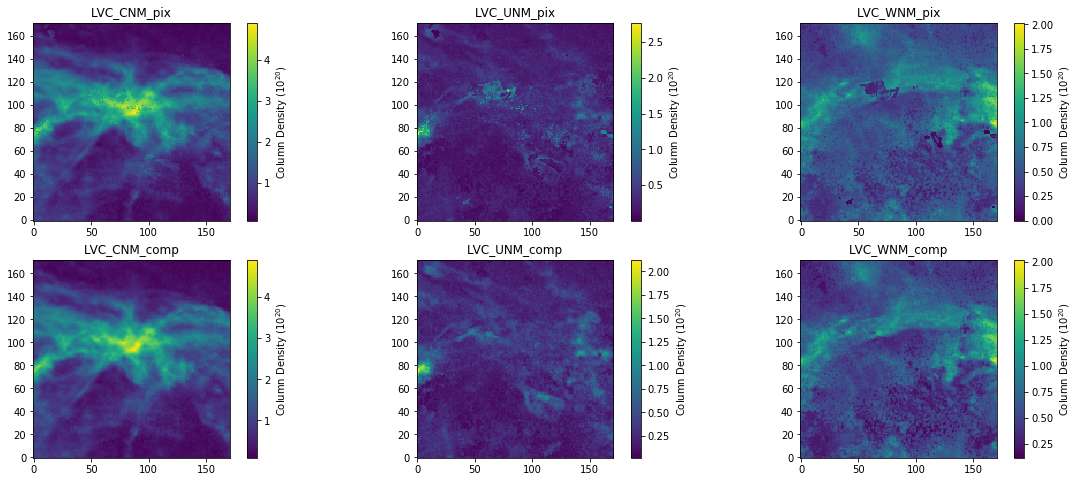

In [38]:
# Plot of the LVC maps (CNM, UNM and WNM)
fig = plt.figure(figsize=(20,8))
plt.subplot(2,3,1) ; plt.title("LVC_CNM_pix")
plt.imshow((1/(10**20))*np.sum(model_LVC_CNM_pix * C * dv, 0), origin="lower") ; plt.colorbar(label="Column Density (10$^{20}$)")
plt.subplot(2,3,2) ; plt.title("LVC_UNM_pix")
plt.imshow((1/(10**20))*np.sum(model_LVC_UNM_pix * C * dv, 0), origin="lower") ; plt.colorbar(label="Column Density (10$^{20}$)")
plt.subplot(2,3,3) ; plt.title("LVC_WNM_pix")
plt.imshow((1/(10**20))*np.sum(model_LVC_WNM_pix * C * dv, 0), origin="lower") ; plt.colorbar(label="Column Density (10$^{20}$)")
plt.subplot(2,3,4) ; plt.title("LVC_CNM_comp")
plt.imshow((1/(10**20))*np.sum(model_LVC_CNM_comp * C * dv, 0), origin="lower") ; plt.colorbar(label="Column Density (10$^{20}$)")
plt.subplot(2,3,5) ; plt.title("LVC_UNM_comp")
plt.imshow((1/(10**20))*np.sum(model_LVC_UNM_comp * C * dv, 0), origin="lower") ; plt.colorbar(label="Column Density (10$^{20}$)")
plt.subplot(2,3,6) ; plt.title("LVC_WNM_comp")
plt.imshow((1/(10**20))*np.sum(model_LVC_WNM_comp * C * dv, 0), origin="lower") ; plt.colorbar(label="Column Density (10$^{20}$)")
plt.subplots_adjust(wspace=0.1)
fig.savefig("Column_Density_maps_of_LVC.pdf", bbox_inches='tight')

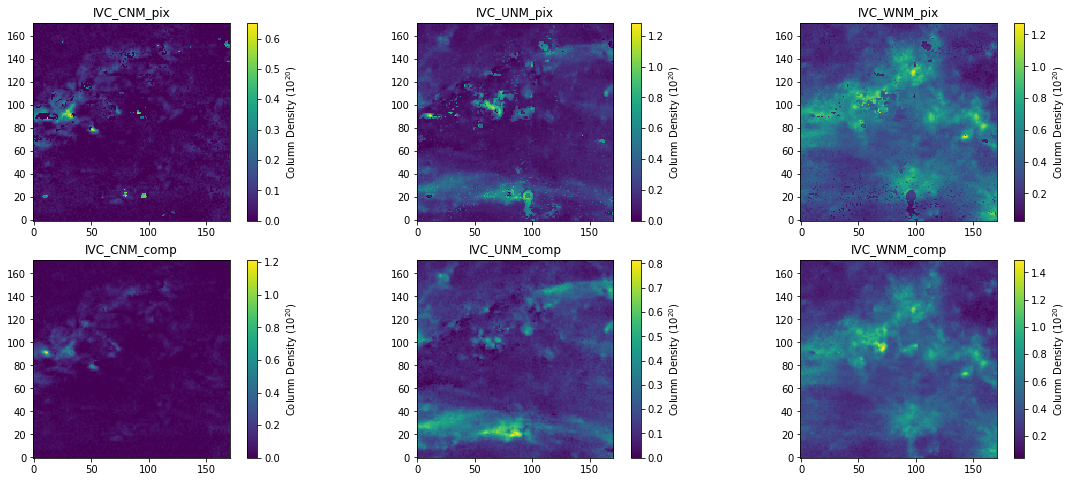

In [39]:
# Plot of the IVC maps (CNM, UNM and WNM)
fig = plt.figure(figsize=(20,8))
plt.subplot(2,3,1) ; plt.title("IVC_CNM_pix")
plt.imshow((1/(10**20))*np.sum(model_IVC_CNM_pix * C * dv, 0), origin="lower") ; plt.colorbar(label="Column Density (10$^{20}$)")
plt.subplot(2,3,2) ; plt.title("IVC_UNM_pix")
plt.imshow((1/(10**20))*np.sum(model_IVC_UNM_pix * C * dv, 0), origin="lower") ; plt.colorbar(label="Column Density (10$^{20}$)")
plt.subplot(2,3,3) ; plt.title("IVC_WNM_pix")
plt.imshow((1/(10**20))*np.sum(model_IVC_WNM_pix * C * dv, 0), origin="lower") ; plt.colorbar(label="Column Density (10$^{20}$)")
plt.subplot(2,3,4) ; plt.title("IVC_CNM_comp")
plt.imshow((1/(10**20))*np.sum(model_IVC_CNM_comp * C * dv, 0), origin="lower") ; plt.colorbar(label="Column Density (10$^{20}$)")
plt.subplot(2,3,5) ; plt.title("IVC_UNM_comp")
plt.imshow((1/(10**20))*np.sum(model_IVC_UNM_comp * C * dv, 0), origin="lower") ; plt.colorbar(label="Column Density (10$^{20}$)")
plt.subplot(2,3,6) ; plt.title("IVC_WNM_comp")
plt.imshow((1/(10**20))*np.sum(model_IVC_WNM_comp * C * dv, 0), origin="lower") ; plt.colorbar(label="Column Density (10$^{20}$)")
plt.subplots_adjust(wspace=0.1)
fig.savefig("Column_Density_maps_of_IVC.pdf", bbox_inches='tight')

Also, I can plot a single spectrum and plot one of the above models against the original data to see just how the models are separate.

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys


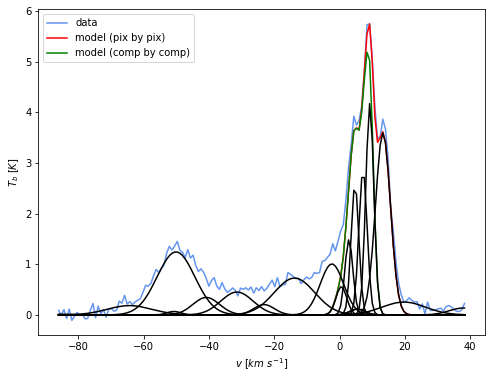

In [40]:
x_pos_whole_spider = 106          #np.random.randint(0,171) ; print("x = ", x_pos_whole_spider)
y_pos_whole_spider = 44           #np.random.randint(0,171) ; print("y = ", y_pos_whole_spider)

plot_spect(x_pos_whole_spider, y_pos_whole_spider, subvel_whole_spider,\
           model_LVC_CNM_pix[:, y_pos_whole_spider, x_pos_whole_spider], \
           subcube_whole_spider[:, y_pos_whole_spider, x_pos_whole_spider], gaussian_whole_spider, \
           model_LVC_CNM_comp[:, y_pos_whole_spider, x_pos_whole_spider], "Spectrum_of_Phase_LVC_CNM_model.pdf")

Notice how here, since I am plotting the model corresponding the LVC_CNM, the models (red and green) are only representing the Gaussian functions in the LVC and that are CNM.

## Plot of the mass fractions of the phases

In [41]:
NH_mass_frac_LVC_CNM = np.sum(model_LVC_CNM_pix, 0) / np.sum(subcube_whole_spider, 0)
NH_mass_frac_LVC_UNM = np.sum(model_LVC_UNM_pix, 0) / np.sum(subcube_whole_spider, 0)
NH_mass_frac_LVC_WNM = np.sum(model_LVC_WNM_pix, 0) / np.sum(subcube_whole_spider, 0)
NH_mass_frac_IVC_CNM = np.sum(model_IVC_CNM_pix, 0) / np.sum(subcube_whole_spider, 0)
NH_mass_frac_IVC_UNM = np.sum(model_IVC_UNM_pix, 0) / np.sum(subcube_whole_spider, 0)
NH_mass_frac_IVC_WNM = np.sum(model_IVC_WNM_pix, 0) / np.sum(subcube_whole_spider, 0)

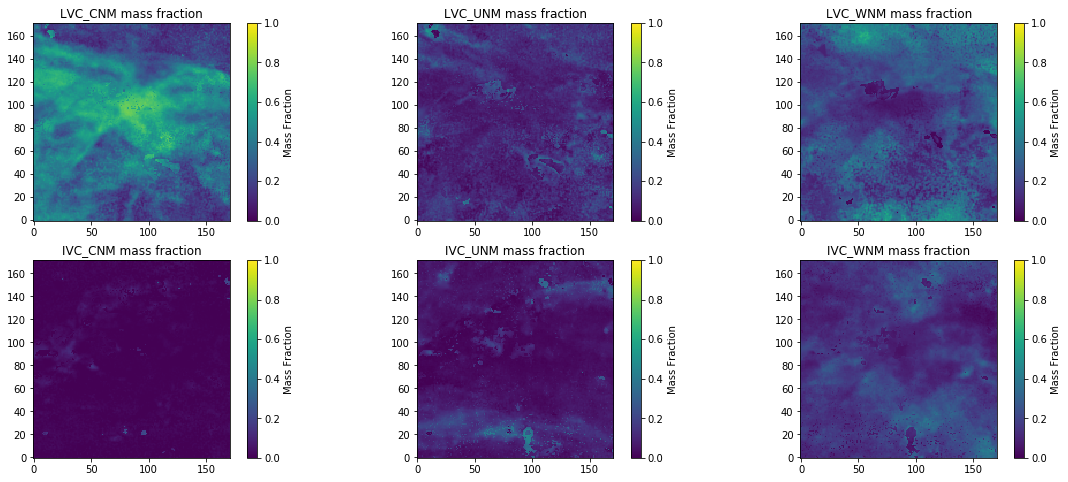

In [42]:
fig = plt.figure(figsize=(20,8))
plt.subplot(2,3,1)
plt.title("LVC_CNM mass fraction")
plt.imshow(NH_mass_frac_LVC_CNM, origin="lower", vmin=0., vmax=1.0) ; plt.colorbar(label="Mass Fraction")
plt.subplot(2,3,2)
plt.title("LVC_UNM mass fraction")
plt.imshow(NH_mass_frac_LVC_UNM, origin="lower", vmin=0., vmax=1.0) ; plt.colorbar(label="Mass Fraction")
plt.subplot(2,3,3)
plt.title("LVC_WNM mass fraction")
plt.imshow(NH_mass_frac_LVC_WNM, origin="lower", vmin=0., vmax=1.0) ; plt.colorbar(label="Mass Fraction")
plt.subplot(2,3,4)
plt.title("IVC_CNM mass fraction")
plt.imshow(NH_mass_frac_IVC_CNM, origin="lower", vmin=0., vmax=1.0) ; plt.colorbar(label="Mass Fraction")
plt.subplot(2,3,5)
plt.title("IVC_UNM mass fraction")
plt.imshow(NH_mass_frac_IVC_UNM, origin="lower", vmin=0., vmax=1.0) ; plt.colorbar(label="Mass Fraction")
plt.subplot(2,3,6)
plt.title("IVC_WNM mass fraction")
plt.imshow(NH_mass_frac_IVC_WNM, origin="lower", vmin=0., vmax=1.0) ; plt.colorbar(label="Mass Fraction")

plt.subplots_adjust(wspace=0.1)
fig.savefig("Mass_fraction_comparison_of_phases_whole_spider.pdf", bbox_inches="tight")

## Plot mosaics of the maps (column density, velocity, and dispersion)

Column Density maps:

<Figure size 432x288 with 0 Axes>

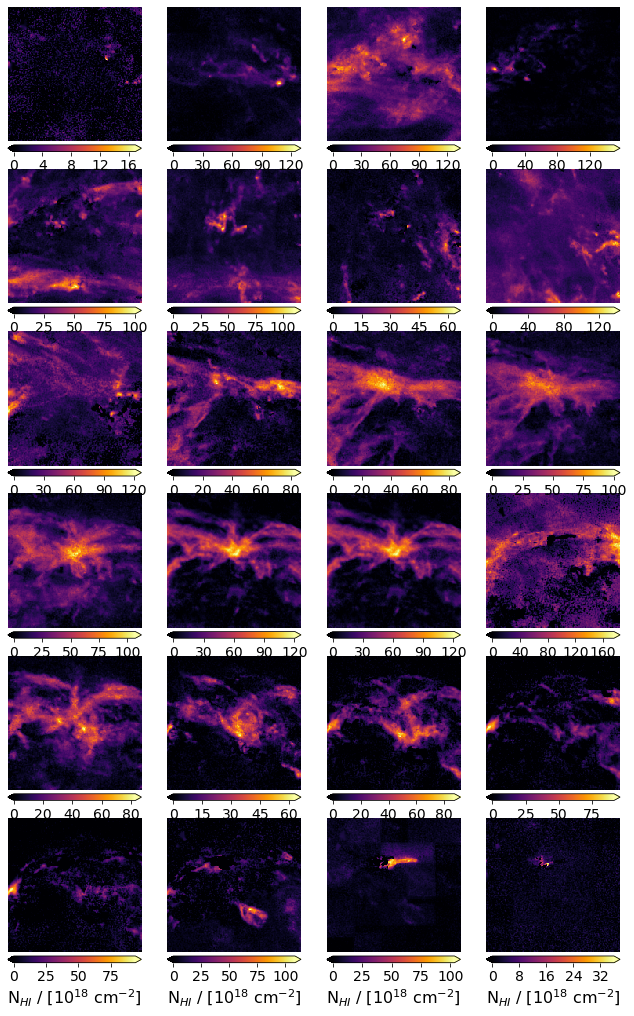

In [43]:
def cm2inch(*tupl):
        inch = 2.54
        if isinstance(tupl[0], tuple):
            return tuple(i/inch for i in tupl[0])
        else:
            return tuple(i/inch for i in tupl)
fig = plt.figure()       
#Plot mosaic field                                                                                                                                                                                                                                                                                                         
lh = 6; lw = 4
fig, axs = plt.subplots(lh, lw, sharex=True, sharey=True, figsize=(cm2inch((22.,35.5))))
fig.subplots_adjust(top=1., bottom=0.05, left=0., right=1., hspace=0.12, wspace=0.1)
k = 0
for i in np.arange(lh):
    for j in np.arange(lw):
        im = axs[i][j].imshow(field[k]/10**18, origin="lower", cmap="inferno")
        if j == 0: axs[i][j].set_ylabel(r'y')
        axs[i][j].set_xlabel(r'x')
        axs[i][j].axes.xaxis.set_ticklabels([])
        axs[i][j].axis('off')
        divider = make_axes_locatable(axs[i][j])
        cax = divider.append_axes('bottom', size='5%', pad=0.05)
        cbar = fig.colorbar(im, cax=cax, orientation='horizontal', extend="both")
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
        cbar.ax.tick_params(labelsize=14.)
        if i == lh-1 : cbar.set_label(r"N$_{HI}$ / [10$^{18}$ cm$^{-2}$]", fontsize=16.)
        k += 1
fig.savefig("Column_Density_whole_spider.pdf", bbox_inches="tight")
# plt.axis('off')
#plt.savefig('plot/mosaic_field.pdf', format='pdf')

Velocity maps:

<Figure size 432x288 with 0 Axes>

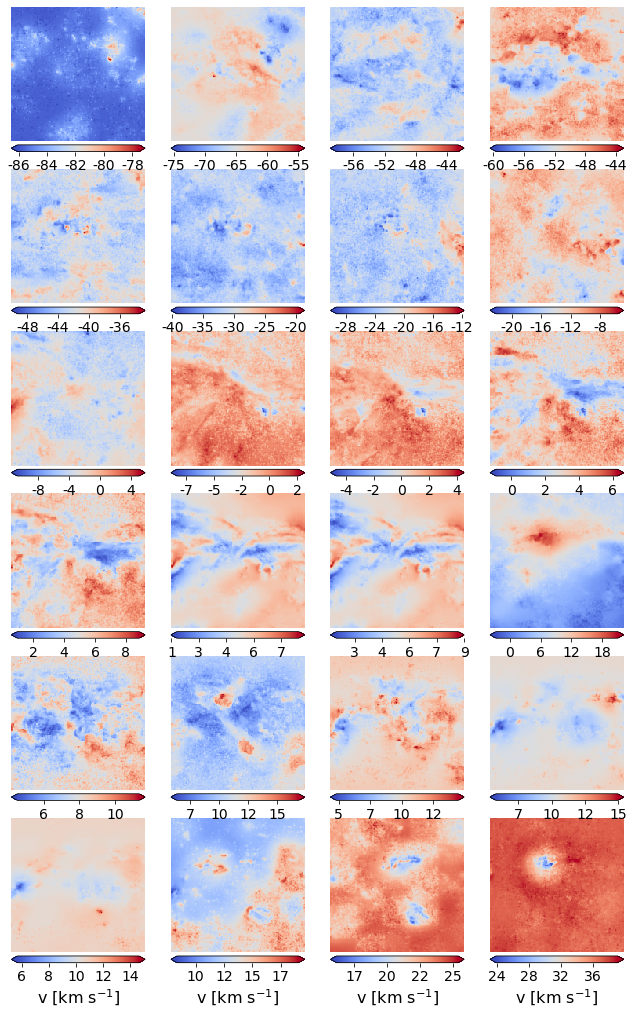

In [44]:
#Plot mosaic field mean
fig = plt.figure()
lh = 6; lw = 4
fig, axs = plt.subplots(lh, lw, sharex=True, sharey=True, figsize=(cm2inch((22.,35.5))))
fig.subplots_adjust(top=1., bottom=0.05, left=0., right=1., hspace=0.12, wspace=0.1)
k = 0
for i in np.arange(lh):
    for j in np.arange(lw):
        elev_min=np.nanmin(vfield[k])
        elev_max=np.nanmax(vfield[k])
        mid_val=0
        im1 = axs[i][j].imshow(vfield[k], origin="lower", cmap="coolwarm")
        if j == 0: axs[i][j].set_ylabel(r'y')
        axs[i][j].set_xlabel(r'x')
        axs[i][j].axes.xaxis.set_ticklabels([])
        axs[i][j].axis('off')
        divider = make_axes_locatable(axs[i][j])
        cax = divider.append_axes('bottom', size='5%', pad=0.05)
        cbar = fig.colorbar(im1, cax=cax, orientation='horizontal', format='%d', extend="both")
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
        cbar.ax.tick_params(labelsize=14.)
        if i == lh-1 : cbar.set_label(r"v [km s$^{-1}$]", fontsize=16.)
        k += 1
fig.savefig("Velcity_whole_spider.pdf", bbox_inches="tight")
# plt.axis('off')                                                                                                                                                                                                                                                                                                          
#plt.savefig('plot/mosaic_vfield.pdf', format='pdf')

Velocity Dispersion maps:

<Figure size 432x288 with 0 Axes>

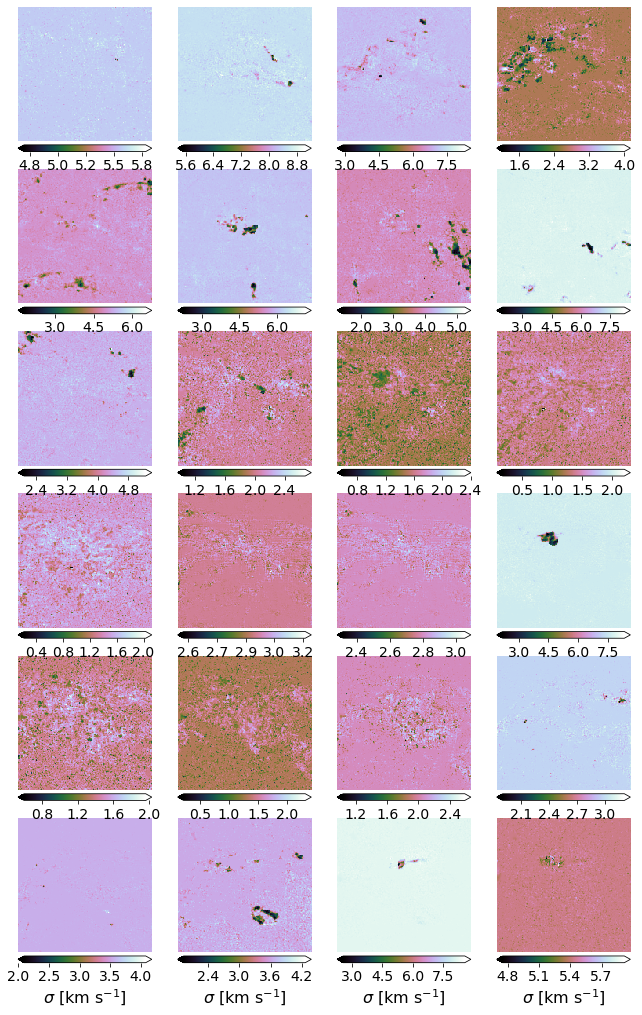

In [45]:
#Plot mosaic field sigma   
fig = plt.figure()
lh = 6; lw = 4
fig, axs = plt.subplots(lh, lw, sharex=True, sharey=True, figsize=(cm2inch((22.,35.5))))
fig.subplots_adjust(top=1., bottom=0.05, left=0., right=1., hspace=0.12, wspace=0.1)
k = 0
for i in np.arange(lh):
    for j in np.arange(lw):
        im1 = axs[i][j].imshow(sigfield[k], origin="lower", cmap="cubehelix")
        if j == 0: axs[i][j].set_ylabel(r'y')
        axs[i][j].set_xlabel(r'x')
        axs[i][j].axes.xaxis.set_ticklabels([])
        axs[i][j].axis('off')
        divider = make_axes_locatable(axs[i][j])
        cax = divider.append_axes('bottom', size='5%', pad=0.05)
        cbar = fig.colorbar(im1, cax=cax, orientation='horizontal', format='%.1f', extend="both")
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
        cbar.ax.tick_params(labelsize=14.)
        if i == lh-1 : cbar.set_label(r"$\sigma$ [km s$^{-1}$]", fontsize=16.)
        k += 1
fig.savefig("Velocity_Dispersion_whole_spider.pdf", bbox_inches="tight")
# plt.axis('off')                                                                                                                                                                                                                                                                                                          
#plt.savefig('plot/mosaic_sigfield.pdf', format='pdf')

## Plot a residual map

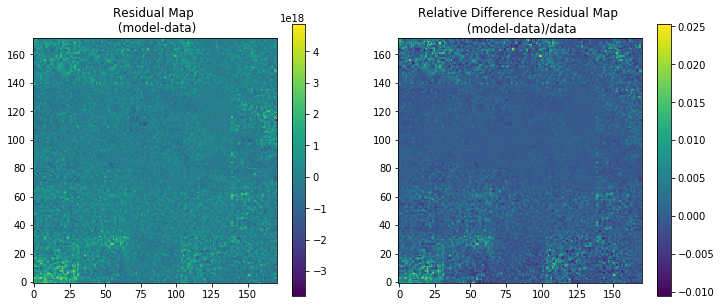

In [46]:
# Find the residual map
fig=plt.figure(figsize=(12,5))
mdl_whole_spider = np.sum(model_whole_spider[:400] , 0)*C*dv
dat_whole_spider = np.sum(subcube_whole_spider[:400], 0)*C*dv
res_whole_spider = (mdl_whole_spider - dat_whole_spider)
plt.subplot(1,2,1) ; plt.title("Residual Map \n (model-data)")
plt.imshow(res_whole_spider, origin="lower")
plt.colorbar()
plt.subplot(1,2,2) ; plt.title("Relative Difference Residual Map \n (model-data)/data")
plt.imshow(res_whole_spider/dat_whole_spider, origin="lower")
plt.colorbar()
fig.savefig("Residual_map_whole_spider.pdf", bbox_inches="tight")

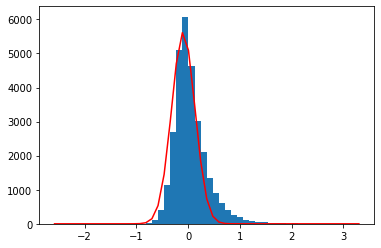

In [47]:
fig = plt.figure()
y_tot,x_tot,_ = plt.hist((res_whole_spider/C/dv).ravel(), bins=50)
# Use scipy.curve_fit to get the gaussain fit for this histogram
#Guesses for the parameters:
amp_tot=3000.; cent_tot=0.2; sig_tot=1
popt, pcov = curve_fit(one_gauss_func, x_tot[:-1], y_tot, p0=[amp_tot,cent_tot,sig_tot])

plt.plot(x_tot, one_gauss_func(x_tot,*popt), 'r')
plt.show()
#fig.savefig("Histogram_of_total_residual.pdf", bbox_inches="tight")

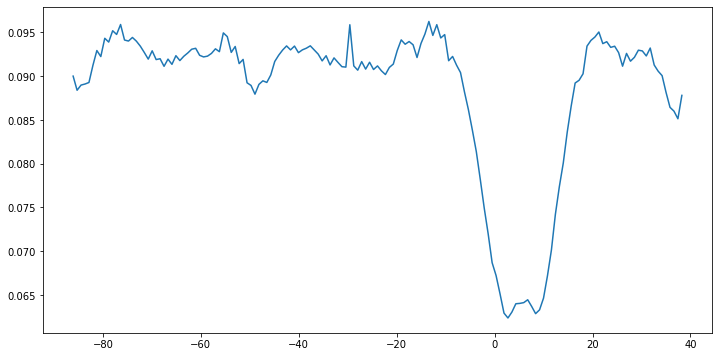

In [48]:
# Standard deviation spectrum
difference_cube = model_whole_spider - subcube_whole_spider
fig = plt.figure(figsize=(12,6))
plt.plot(subvel_whole_spider, np.std((difference_cube), (1,2)))
plt.show()
fig.savefig("Standard_Deviation_spectrum_whole_spider.pdf", bbox_inches='tight')

## Write out to .fits file

In [49]:
#new_hdr = fits.Header()
new_hdr = hdr

In [50]:
empty_primary = fits.PrimaryHDU(_______, header=new_hdr)

hdulist = fits.HDUList([empty_primary])
hdulist.writeto("_______.fits", clobber=True)

NameError: name '_______' is not defined